In [11]:
#import necessary packages
import numpy as np
import pandas as pd 
import os,sys

import pickle
from local.scoring import score
from pdb import set_trace as bp

In [17]:

#mention the rootdir based on what model scores to be fused for all modalities
rootdir = 'classifier_BLSTM_model'

sys.path.append(rootdir)

#folder inside rootdir where the val and test prediction scores are present
res_folder=os.path.join(rootdir, 'results')

# select 'audio_fusion_combs' if 9 audio modalities to be fused. Select 'fusion_combs' if 9 audio modalities+symptom to be fused
#save_folder='audio_fusion_combs'
save_folder='fusion_combs'

# val
test_scorefil="val_scores.txt"
tst='val'

# test
new_test_dir='{}/data'.format(rootdir)
new_test='test1_test2'
new_test_scorefil='test1_test2_scores.txt'


# select based on 9 audio modalities to be fused or 9 audio modalities+symptom to be fused
audio_categories = ['breathing-deep', 
                    'breathing-shallow', 
                    'cough-heavy', 
                    'cough-shallow', 
                    'vowel-a', 
                    'vowel-e', 
                    'vowel-o', 
                    'counting-normal', 
                    'counting-fast',
                   'symptoms'
                   ]
# audio_categories = ['breathing-deep', 
#                     'breathing-shallow', 
#                     'cough-heavy', 
#                     'cough-shallow', 
#                     'vowel-a', 
#                     'vowel-e', 
#                     'vowel-o', 
#                     'counting-normal', 
#                     'counting-fast',
#                    ]

for idx, audio_category in enumerate(audio_categories):
    df=pd.read_csv(os.path.join(rootdir, res_folder, audio_category, test_scorefil), sep=" ", header=None)
    keylist=list(df[0])
    if idx==0:
        temp=list(set(keylist))
    else:
        temp=list(set(temp) & set(keylist))
    
    
common_ids=temp  
print(common_ids[:3])
print(len(common_ids))

['88mEmnYlbaPo3iQRZGn8Fbm9mNs1', 'NAL6D2MCyQbiZUGtdQixl39IH3X2', 'fezNxeyeMSSvqIiQvCsQROuhbNv1']
240


In [18]:
def scoring_v2(reference_labels, sys_scores,specificities_chosen=[0.5,0.95]):

    thresholds=np.arange(0,1,0.0001)

    AUC, TPR, TNR = score(reference_labels,sys_scores,thresholds=thresholds)

    specificities=[]
    sensitivities=[]

    decision_thresholds = []
    for specificity_threshold in specificities_chosen:
        ind = np.where(TNR>specificity_threshold)[0]
        sensitivities.append( TPR[ind[0]])
        specificities.append( TNR[ind[0]])
        decision_thresholds.append( thresholds[ind[0]])

    # pack the performance metrics in a dictionary to save & return
    # Each performance metric (except AUC) is a array for different threshold values
    # Specificity at 90% sensitivity
    scores={'TPR':TPR,
            'FPR':1-TNR,
            'AUC':AUC,
            'sensitivity':sensitivities,
            'specificity':specificities,
            'operatingPts':decision_thresholds,
			'thresholds':thresholds}

    return AUC,sensitivities[0],specificities[0],sensitivities[1],specificities[1], decision_thresholds[1]

In [20]:
test_lines=open('{}/data/{}'.format(rootdir,tst),'r').readlines()
test_labels_dict={}
test_labels=[]
for line in test_lines:
    key, val = line.strip().split(" ")
    if val=='p':
        val=1
    elif val=='n':
        val=0
    else:
        raise ValueError(" Not a valid label.")
    if key in common_ids:
        test_labels_dict[key]=val
test_labels=[float(test_labels_dict[id]) for id in common_ids]
print(test_labels[-10:])
print(len(test_labels))

[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
240


In [21]:
for idx, audio_category in enumerate(audio_categories):
    dict={}
    test_scores=[]
    test_score_lines=open(os.path.join(rootdir,res_folder, audio_category,test_scorefil),'r').readlines()

    
    for line in test_score_lines:
        key, val=line.strip().split(" ")
        if key in common_ids:
            dict[key]=val
    assert sorted(list(dict.keys()))==sorted(common_ids)


    test_scores=[float(dict[key]) for key in common_ids]
   
    test_scores=np.array(test_scores)
    
    test_scores=test_scores.reshape(-1,1)
    auc, _,_,sens,spec,_=scoring_v2(list(test_labels), list(test_scores))
    print("{}--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f}".format(audio_category, auc, sens, spec))

    
    if idx==0:
        test_score_arr=test_scores
        
    else:
        test_score_arr=np.concatenate((test_score_arr, test_scores), axis=1)
    
print(test_score_arr.shape)
print(test_score_arr)



breathing-deep--AUC: 0.7435, Sens: 0.2623, Spec: 0.9553
breathing-shallow--AUC: 0.6827, Sens: 0.1311, Spec: 0.9553
cough-heavy--AUC: 0.7316, Sens: 0.3115, Spec: 0.9553
cough-shallow--AUC: 0.6953, Sens: 0.3115, Spec: 0.9553
vowel-a--AUC: 0.7081, Sens: 0.2951, Spec: 0.9553
vowel-e--AUC: 0.6970, Sens: 0.2623, Spec: 0.9553
vowel-o--AUC: 0.6766, Sens: 0.3607, Spec: 0.9553
counting-normal--AUC: 0.7574, Sens: 0.3279, Spec: 0.9553
counting-fast--AUC: 0.8088, Sens: 0.3770, Spec: 0.9553
symptoms--AUC: 0.8598, Sens: 0.7213, Spec: 0.9553
(240, 10)
[[0.325046   0.39201458 0.53826638 ... 0.27410221 0.11048874 0.19674129]
 [0.31013379 0.32981194 0.42047904 ... 0.48620416 0.25511303 0.19674129]
 [0.10597375 0.09296513 0.10507626 ... 0.17551205 0.17402098 0.19674129]
 ...
 [0.3740682  0.2930933  0.23199759 ... 0.53267235 0.54848655 0.90510313]
 [0.28381235 0.33406363 0.28550202 ... 0.46478714 0.59486165 0.19674129]
 [0.40546955 0.81487496 0.18097254 ... 0.26202313 0.16704984 0.19674129]]


In [22]:
# Baseline score
# from scoring import score
baseline_test_score=np.mean(test_score_arr, axis=1)
auc,_,_,sens,spec,thres=scoring_v2(list(test_labels), list(baseline_test_score))
print("fusion--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f} at thres:{:.4f}".format(auc, sens, spec,thres))



fusion--AUC: 0.8357, Sens: 0.4426, Spec: 0.9553 at thres:0.4837


max weight: [[0.01277924]
 [0.08344069]
 [0.01948327]
 [0.17143898]
 [0.05640594]
 [0.0125827 ]
 [0.14201155]
 [0.05148105]
 [0.08081177]
 [0.36956482]]


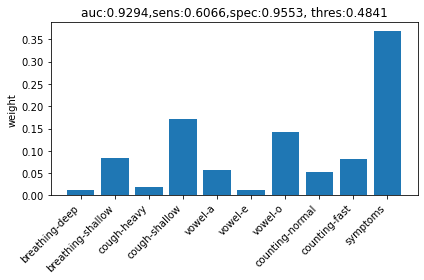



max weight: [[0.00067203]
 [0.06067213]
 [0.09910066]
 [0.06030157]
 [0.0912521 ]
 [0.05376664]
 [0.01891895]
 [0.01298194]
 [0.27651679]
 [0.32581719]]


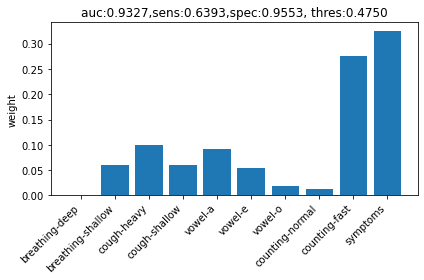



max weight: [[0.05771294]
 [0.11069737]
 [0.0473921 ]
 [0.06827458]
 [0.05994845]
 [0.04603808]
 [0.0441044 ]
 [0.03983005]
 [0.03679463]
 [0.48920739]]


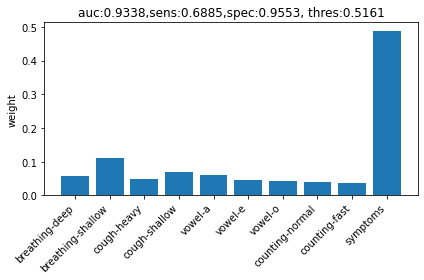



max weight: [[0.03862183]
 [0.00604124]
 [0.07480284]
 [0.02335107]
 [0.11028173]
 [0.00155925]
 [0.12117503]
 [0.25042977]
 [0.02714024]
 [0.34659699]]


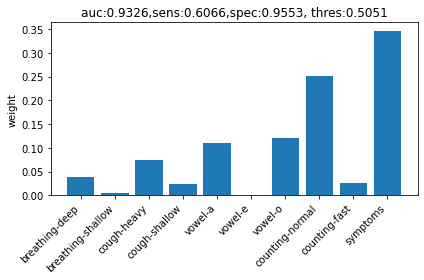



max weight: [[0.02519572]
 [0.02285158]
 [0.06610843]
 [0.04765101]
 [0.17034905]
 [0.00136038]
 [0.04894886]
 [0.0144584 ]
 [0.28253339]
 [0.32054316]]


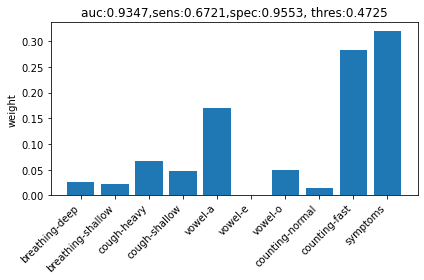



max weight: [[0.01570733]
 [0.12615411]
 [0.08306849]
 [0.05522409]
 [0.02997742]
 [0.01312955]
 [0.04263243]
 [0.1362005 ]
 [0.08117862]
 [0.41672747]]


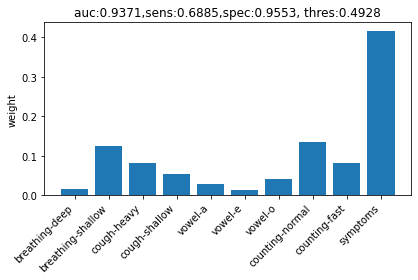



max weight: [[0.0514083 ]
 [0.02826577]
 [0.22572704]
 [0.10178253]
 [0.04069872]
 [0.02273527]
 [0.07780853]
 [0.05269302]
 [0.00423574]
 [0.39464508]]


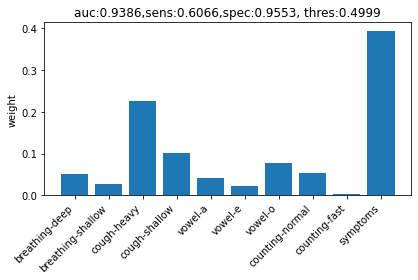



max weight: [[0.05957759]
 [0.02251947]
 [0.031697  ]
 [0.00649884]
 [0.21740829]
 [0.02178163]
 [0.00789985]
 [0.02716746]
 [0.19787832]
 [0.40757155]]


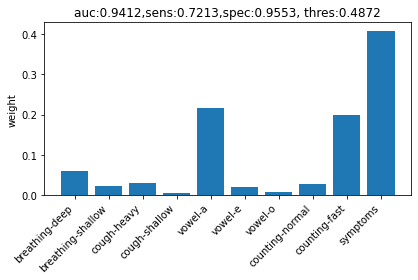



max weight: [[0.07052548]
 [0.00685912]
 [0.15219399]
 [0.00329629]
 [0.07793948]
 [0.10578084]
 [0.02547541]
 [0.10052864]
 [0.15482286]
 [0.30257789]]


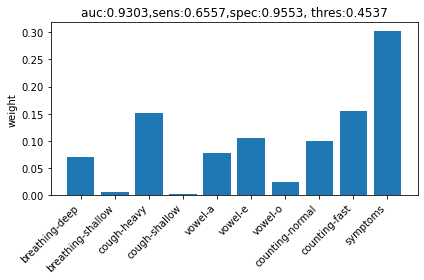



max weight: [[0.12912183]
 [0.04376751]
 [0.05862117]
 [0.09558464]
 [0.14928889]
 [0.03165456]
 [0.04060127]
 [0.02106924]
 [0.01965894]
 [0.41063196]]


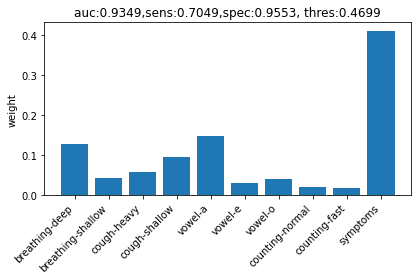

In [23]:
import matplotlib.pyplot as plt 
import pickle

best_weights=[]

for iter in range(10):
    tst_aucs = []
    tst_sens=[]
    tst_specs=[]
    weights = []
    thresholds= []

    for i in range(100):
        alphas=np.ones(len(audio_categories),np.float32)
        s = np.random.dirichlet(alphas,1)
        s = s.reshape(-1,1)
        w_score = np.matmul(test_score_arr, s)
        auc, _, _, sens,spec,threshold = scoring_v2(list(test_labels), list(w_score))
        tst_aucs.append(auc)
        tst_sens.append(sens)
        tst_specs.append(spec)
        weights.append(s)
        thresholds.append(threshold)


        
    max_idx = np.array(tst_aucs).argmax()
    max_weight = np.array(weights[max_idx])
    best_weights.append(max_weight)
    print("max weight: {}".format(max_weight))
    max_auc=tst_aucs[max_idx]
    max_sens=tst_sens[max_idx]
    max_spec=tst_specs[max_idx]
    max_threshold=thresholds[max_idx]

    category_dict={}
    for idx, audio_category in enumerate(audio_categories):
        category_dict[audio_category]=max_weight[idx].item()

    

    fig = plt.figure()
    plt.bar(range(len(category_dict)), list(category_dict.values()))
    plt.xticks(range(len(category_dict)), list(category_dict.keys()), rotation=45,horizontalalignment='right')
    plt.title('auc:{:.4f},sens:{:.4f},spec:{:.4f}, thres:{:.4f}'.format(max_auc,max_sens,max_spec, max_threshold))
    
    dir='{}/{}/val_data/'.format(res_folder, save_folder)
    if not os.path.exists(dir):
        os.makedirs(dir)
    plt.ylabel('weight')
    plt.tight_layout()
    plt.savefig(dir + '/c{}.png'.format(iter))
    plt.show()

    plt.close()
    print("\n")

with open('{}/{}/val_data/best_weights.pkl'.format(res_folder,save_folder),'wb') as f:
   pickle.dump(best_weights, f,protocol=pickle.HIGHEST_PROTOCOL)


### **New test data**

In [24]:


for idx, audio_category in enumerate(audio_categories):
    #print(audio_category)
    #scores=open(os.path.join(rootdir,audiocategory,'train_scores.txt')).readlines()
    df=pd.read_csv(os.path.join(rootdir, res_folder, audio_category,new_test_scorefil ), sep=" ", header=None)
    keylist=list(df[0])
    #print(len(keylist))
    if idx==0:
        temp=list(set(keylist))
    else:
        temp=list(set(temp) & set(keylist))
    #print(len(temp))
    
new_common_ids=temp  
print(new_common_ids[:3])
print(len(new_common_ids))

['HIfH8OY3VQYcGEsFKVNh9m9qYer1', 'ARnHOwUIKyfpC9ryG6AqrTcksmq1', 'KJQP1HlxlwfYbc7ogIxZ2Hklyym2']
400


In [26]:
new_test_lines=open('{}/{}'.format(new_test_dir, new_test),'r').readlines()
#test_lines.sort()
new_test_labels_dict={}
new_test_labels=[]

for line in new_test_lines:
    key, val = line.strip().split(" ")
    if val=='p':
        val=1
    elif val=='n':
        val=0
    else:
        raise ValueError(" Not a valid label.")
    if key in new_common_ids:
        new_test_labels_dict[key]=val
        
new_test_labels=[float(new_test_labels_dict[id]) for id in new_common_ids]
print(new_test_labels[-10:])
print(len(new_test_labels))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
400


In [27]:
for idx, audio_category in enumerate(audio_categories):
    new_dict={}
    new_test_scores=[]
    new_test_score_lines=open(os.path.join(rootdir, res_folder, audio_category, new_test_scorefil),'r').readlines()
  
    
    for line in new_test_score_lines:
        key, val=line.strip().split(" ")
        if key in new_common_ids:
            new_dict[key]=val
    assert sorted(list(new_dict.keys()))==sorted(new_common_ids)
    

    new_test_scores=[float(new_dict[key]) for key in new_common_ids]
   
    new_test_scores=np.array(new_test_scores)
    
    new_test_scores=new_test_scores.reshape(-1,1)

    auc, _,_,sens,spec,_=scoring_v2(list(new_test_labels), list(new_test_scores))
    print("{}--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f}".format(audio_category, auc, sens, spec))

    if idx==0:
        new_test_score_arr=new_test_scores
        
    else:
        new_test_score_arr=np.concatenate((new_test_score_arr, new_test_scores), axis=1)
    
print(new_test_score_arr.shape)
print(new_test_score_arr)

breathing-deep--AUC: 0.7574, Sens: 0.3400, Spec: 0.9533
breathing-shallow--AUC: 0.7788, Sens: 0.2800, Spec: 0.9533
cough-heavy--AUC: 0.7980, Sens: 0.3200, Spec: 0.9533
cough-shallow--AUC: 0.7656, Sens: 0.3800, Spec: 0.9533
vowel-a--AUC: 0.7934, Sens: 0.2800, Spec: 0.9533
vowel-e--AUC: 0.7732, Sens: 0.3300, Spec: 0.9533
vowel-o--AUC: 0.7357, Sens: 0.2200, Spec: 0.9533
counting-normal--AUC: 0.8078, Sens: 0.3100, Spec: 0.9533
counting-fast--AUC: 0.7944, Sens: 0.3600, Spec: 0.9533
symptoms--AUC: 0.8492, Sens: 0.5300, Spec: 0.9533
(400, 10)
[[0.27293892 0.20821455 0.32083151 ... 0.67612414 0.72366979 0.90510313]
 [0.13031137 0.11214916 0.0535913  ... 0.0619139  0.26457298 0.19674129]
 [0.17807035 0.4785203  0.09991854 ... 0.05475778 0.19930042 0.19674129]
 ...
 [0.21259929 0.46481628 0.34982245 ... 0.5257802  0.77256505 0.91943734]
 [0.27554412 0.39980929 0.1075885  ... 0.14319467 0.084743   0.19674129]
 [0.07295561 0.06234606 0.10728228 ... 0.05724747 0.06290573 0.19674129]]


In [28]:
# from scoring import score
new_baseline_test_score=np.mean(new_test_score_arr, axis=1)
auc, _,_,sens,spec,thres=scoring_v2(list(new_test_labels), list(new_baseline_test_score))

print("fusion--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f} at thres:{:.4f}".format(auc, sens, spec,thres))

fusion--AUC: 0.8812, Sens: 0.4700, Spec: 0.9533 at thres:0.5124


In [29]:
s = np.array(best_weights[0]).reshape(-1,1)
s.shape

(10, 1)

In [30]:
print(np.array(best_weights).shape)

(10, 10, 1)


In [31]:
for i in range(np.array(best_weights).shape[0]):
    s = np.array(best_weights[i]).reshape(-1,1)
    #s = np.array([0,0,0,0,0,0,0,0,0,1]).reshape(-1,1)
    w_score = np.matmul(new_test_score_arr, s)
    auc, _, _, sens,spec, thres = scoring_v2(list(new_test_labels), list(w_score))
    print("AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f} at threshold: {:.4f}".format(auc, sens, spec, thres))

AUC: 0.9185, Sens: 0.6000, Spec: 0.9533 at threshold: 0.5419
AUC: 0.9148, Sens: 0.6200, Spec: 0.9533 at threshold: 0.5405
AUC: 0.9191, Sens: 0.6100, Spec: 0.9533 at threshold: 0.6081
AUC: 0.9210, Sens: 0.6000, Spec: 0.9533 at threshold: 0.5365
AUC: 0.9146, Sens: 0.6300, Spec: 0.9533 at threshold: 0.5295
AUC: 0.9177, Sens: 0.5800, Spec: 0.9533 at threshold: 0.5861
AUC: 0.9186, Sens: 0.6100, Spec: 0.9533 at threshold: 0.5532
AUC: 0.9160, Sens: 0.6200, Spec: 0.9533 at threshold: 0.5611
AUC: 0.9174, Sens: 0.6500, Spec: 0.9533 at threshold: 0.5112
AUC: 0.9194, Sens: 0.6500, Spec: 0.9533 at threshold: 0.5432


In [32]:
# put the index corresponding to best AUC obtained in last cell
best_idx = 3

s_best = np.array(best_weights[best_idx]).reshape(-1,1)
w_score_best = np.matmul(new_test_score_arr, s_best)
auc_best, _, _, sens,spec, thres = scoring_v2(list(new_test_labels), list(w_score_best))
print(auc_best)

0.9209666666666667


In [34]:
#save the score file
df_score_best = pd.DataFrame(np.stack([new_common_ids, [i[0] for i in w_score_best]], axis=1))


In [35]:
df_score_best

,0,1
0,HIfH8OY3VQYcGEsFKVNh9m9qYer1,0.6216139095995309
1,ARnHOwUIKyfpC9ryG6AqrTcksmq1,0.14996380437357693
2,KJQP1HlxlwfYbc7ogIxZ2Hklyym2,0.14244448075083788
3,B8eucE77s9Tg8wfQCZIv9JCTDrj2,0.23008313238998068
4,8J17ZUDTdXfN5NYwjjp1ANcRqbJ2,0.3109225346054457
...,...,...
395,IQSMEGOrc3XegUpIARWm07D2K2a2,0.38467299348816
396,6BGTwwcsLoZpqSMhSzFeT2Z7Pqr2,0.1434877646663068
397,sQF52orawHVKB3MgZ746Q6Nby4H3,0.6212466428212473
398,NPwHtrWOTPgBVHkElhwB91qJXts1,0.19702903341787203


In [36]:
save_dir_path = os.path.join(res_folder, save_folder)
if os.path.exists(save_dir_path)==False: os.mkdir(save_dir_path)
df_score_best.to_csv(os.path.join(save_dir_path, 'test1_test2_scores.txt'), header=False, index=False, sep=' ')